In [36]:
import scanpy as sc
import matplotlib.pyplot as plt

In [37]:
train_data_file = '../data/exercise_files/train.h5ad'
test_data_file = '../data/exercise_files/test.h5ad'

In [38]:
adata_train = sc.read_h5ad(train_data_file)
adata_test = sc.read_h5ad(test_data_file)

In [39]:
adata_train.shape

(7000, 27037)

In [40]:
adata_test.shape

(7000, 27037)

In [42]:
adata_train.X[0:10,0:10].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [7., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 2., 0., 1.]], dtype=float32)

In [43]:
adata_train.obs

,cell_type,original_cell_type
run_4_PC-12D.ACTTCCGTTAGTAACGGTC-0,Placodal ectoderm,Placodal area
run_21_PB-02H_S112.TGCGTAGTTCGAGCTGCCA-10,Hindgut,Midgut/Hindgut epithelial cells
run_14_PX-06G_S143.GCTTCTGGTTTCTTAATAA-2,Dorsal spinal cord progenitors,Spinal cord dorsal progenitors
run_16_PC-10C_S267.AAAGCTGATTTTACGATGAA-4,Hindgut,Gut
run_4_PE-02C.ACGCTTATATTGACGCTCCG-0,Midbrain/Hindbrain boundary,Posterior roof plate
...,...,...
run_25_PA-03D_S20.AAGTTCTTGTTTATAAGAAC-14,Venous endothelium,Venous and capillary endothelial cells
run_17_PD-09E_S357.AAGGATTACTAGGTTAGTTC-5,Otic placode,Otic epithelial cells
run_19_PC-09G_S263.AGGCTCGTTCGGTTATGCC-8,Limb mesoderm,Limb mesenchyme progenitors
run_20_PB-04H_S128.GGTACGGATCCAACTAACC-9,Erythroid,Definitive erythroblasts (CD36+)


In [44]:
adata_train.var_names

Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102343',
       'ENSMUSG00000025900', 'ENSMUSG00000025902', 'ENSMUSG00000104328',
       'ENSMUSG00000033845', 'ENSMUSG00000025903', 'ENSMUSG00000104217',
       'ENSMUSG00000033813',
       ...
       'ENSMUSG00000064354', 'ENSMUSG00000064356', 'ENSMUSG00000064357',
       'ENSMUSG00000064358', 'ENSMUSG00000064360', 'ENSMUSG00000065947',
       'ENSMUSG00000064363', 'ENSMUSG00000064367', 'ENSMUSG00000064368',
       'ENSMUSG00000064370'],
      dtype='object', length=27037)

In [45]:
adata_train.layers['X_previous']

array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 2., 0., 0.]], shape=(7000, 27037), dtype=float32)

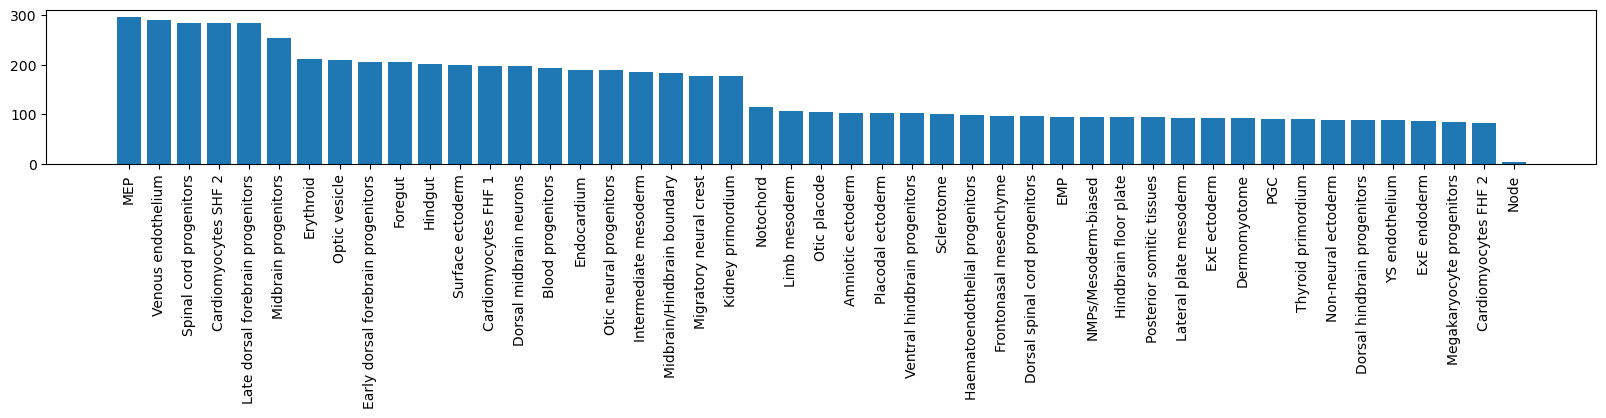

In [65]:
value_counts = adata_train.obs['cell_type'].value_counts()

plt.figure(figsize=(20,2))
plt.bar(value_counts.index, value_counts.values)
plt.xticks(rotation=90)
plt.show()

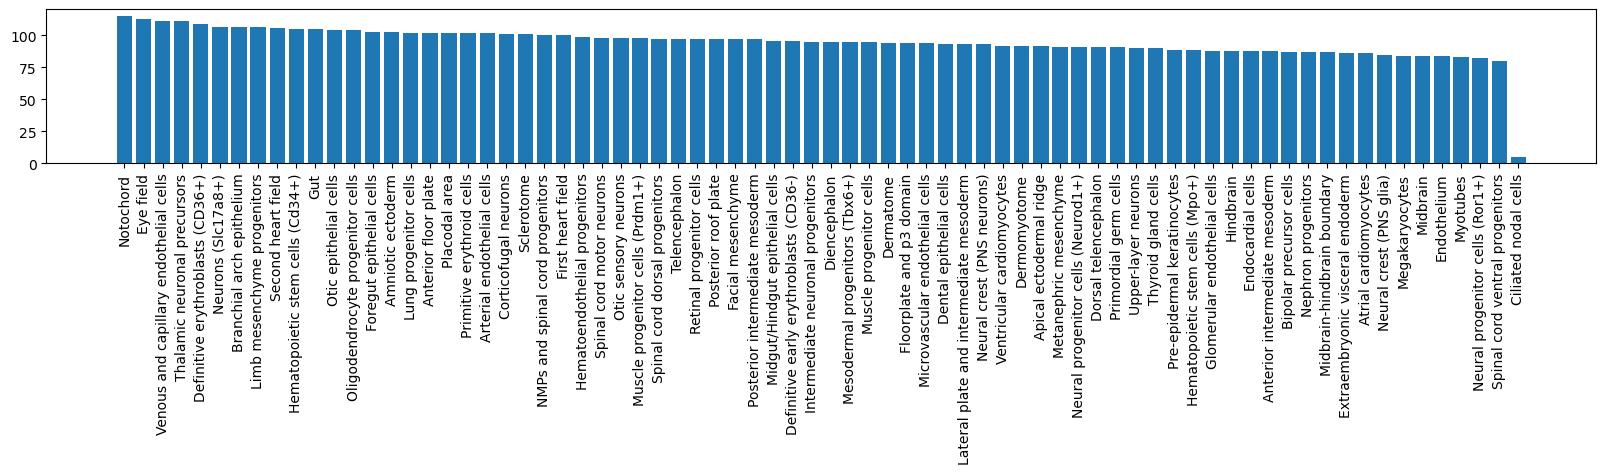

In [67]:
value_counts = adata_train.obs['original_cell_type'].value_counts()

plt.figure(figsize=(20,2))
plt.bar(value_counts.index, value_counts.values)
plt.xticks(rotation=90)
plt.show()

In [68]:
cell_type_intersection = set(adata_train.obs['original_cell_type'].unique()).intersection(set(adata_train.obs['cell_type'].unique()))

In [69]:
cell_type_intersection

{'Amniotic ectoderm', 'Dermomyotome', 'Notochord', 'Sclerotome'}

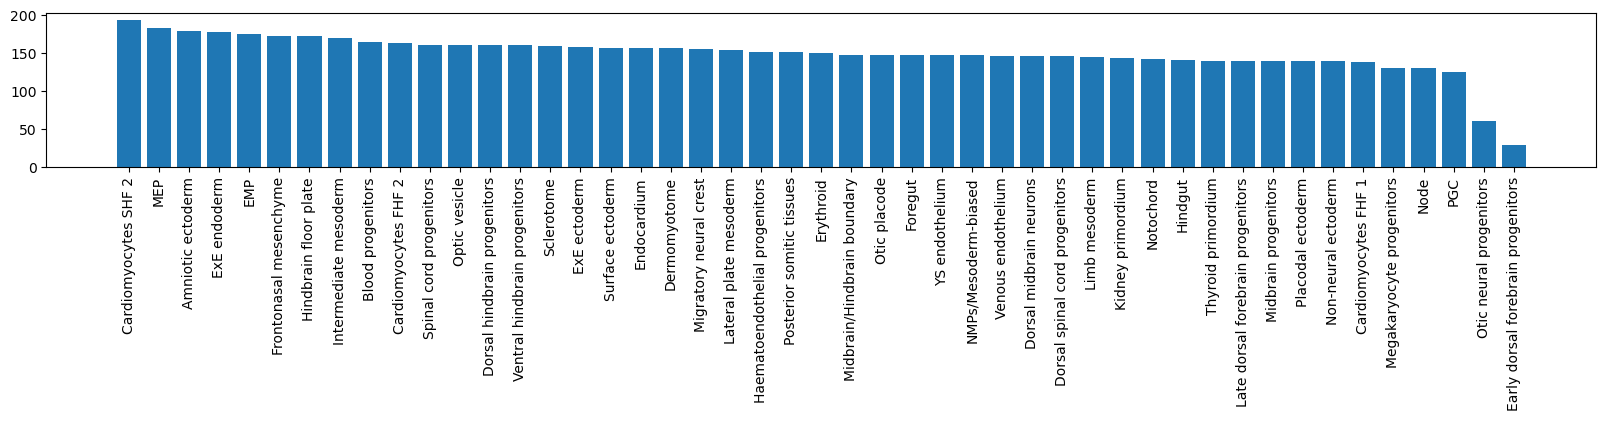

In [66]:
value_counts = adata_test.obs['cell_type'].value_counts()

plt.figure(figsize=(20,2))
plt.bar(value_counts.index, value_counts.values)
plt.xticks(rotation=90)
plt.show()

In [48]:
adata_train.obs['cell_type'].value_counts()

cell_type
MEP                                   295
Venous endothelium                    289
Spinal cord progenitors               284
Cardiomyocytes SHF 2                  284
Late dorsal forebrain progenitors     283
Midbrain progenitors                  253
Erythroid                             211
Optic vesicle                         210
Early dorsal forebrain progenitors    206
Foregut                               205
Hindgut                               201
Surface ectoderm                      200
Cardiomyocytes FHF 1                  198
Dorsal midbrain neurons               197
Blood progenitors                     194
Endocardium                           190
Otic neural progenitors               189
Intermediate mesoderm                 185
Midbrain/Hindbrain boundary           184
Migratory neural crest                178
Kidney primordium                     178
Notochord                             115
Limb mesoderm                         107
Otic placode            

In [32]:
adata_train.obs['original_cell_type'].unique()

['Placodal area', 'Midgut/Hindgut epithelial cells', 'Spinal cord dorsal progenitors', 'Gut', 'Posterior roof plate', ..., 'Nephron progenitors', 'Upper-layer neurons', 'Glomerular endothelial cells', 'Ventricular cardiomyocytes', 'Ciliated nodal cells']
Length: 74
Categories (74, object): ['Amniotic ectoderm', 'Anterior floor plate', 'Anterior intermediate mesoderm', 'Apical ectodermal ridge', ..., 'Thyroid gland cells', 'Upper-layer neurons', 'Venous and capillary endothelial cells', 'Ventricular cardiomyocytes']

In [34]:
adata_test.obs

,cell_type
416058,Venous endothelium
73577,Haematoendothelial progenitors
399126,Migratory neural crest
342525,Cardiomyocytes FHF 2
386175,Foregut
...,...
206722,Ventral hindbrain progenitors
247273,Erythroid
316401,Migratory neural crest
174326,Migratory neural crest
